In [1]:
# @title Dataset Mount
!wget http://dtn-max.ifa.hawaii.edu/SpaceApps/2024/spaceappschallenge_seismicdetection_data.zip
!unzip spaceappschallenge_seismicdetection_data.zip
%cd /content
!ls

--2024-10-08 03:22:43--  http://dtn-max.ifa.hawaii.edu/SpaceApps/2024/spaceappschallenge_seismicdetection_data.zip
Resolving dtn-max.ifa.hawaii.edu (dtn-max.ifa.hawaii.edu)... 206.196.177.123
Connecting to dtn-max.ifa.hawaii.edu (dtn-max.ifa.hawaii.edu)|206.196.177.123|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 756718846 (722M) [application/zip]
Saving to: ‘spaceappschallenge_seismicdetection_data.zip’

spaceappschallenge_ 100%[===================>] 721.66M  82.7MB/s    in 7.5s    

2024-10-08 03:22:51 (95.8 MB/s) - ‘spaceappschallenge_seismicdetection_data.zip’ saved [756718846/756718846]

Archive:  spaceappschallenge_seismicdetection_data.zip
   creating: data/
   creating: data/lunar/
   creating: data/lunar/catalog/
  inflating: data/lunar/catalog/apollo12_catalog_GradeA_final.csv  
   creating: data/lunar/train/
  inflating: data/lunar/train/xa.s12.00.mhz.1971-04-17HR00_evid00030.mseed  
  inflating: data/lunar/train/xa.s12.00.mhz.1973-08-21HR00_evid0

In [1]:
# @title Setup and Build
#Install prerequisite packages
%pip install obspy
%pip install deepod
%pip install noisereduce
%pip install --upgrade torch torchvision
%pip install audiomentations
%pip install --upgrade scipy

  Using cached deepod-0.4.1-py3-none-any.whl.metadata (10 kB)
  Using cached torch-1.13.0-cp310-cp310-manylinux1_x86_64.whl.metadata (23 kB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
Using cached deepod-0.4.1-py3-none-any.whl (203 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
  Attempting uninstall: to

In [3]:
# @title Import Modules
#Import modules
import numpy as np
import pandas as pd
import scipy
from scipy.signal import hilbert,find_peaks
from scipy.interpolate import UnivariateSpline
import obspy
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import typing
from typing import *
import gc
from threading import current_thread
from pickle import GLOBAL
import torch
from torch.nn.utils.rnn import pad_sequence
%matplotlib inline

In [4]:
#GLOBAL VARIABLES
DATASET_ROOT_PATH="data"
LUNAR_FS_ORIGINAL=6.635
MARS_FS_ORIGINAL=20
FS_LUNAR_ACTUAL=0.1
FS_MARS_ACTUAL=3

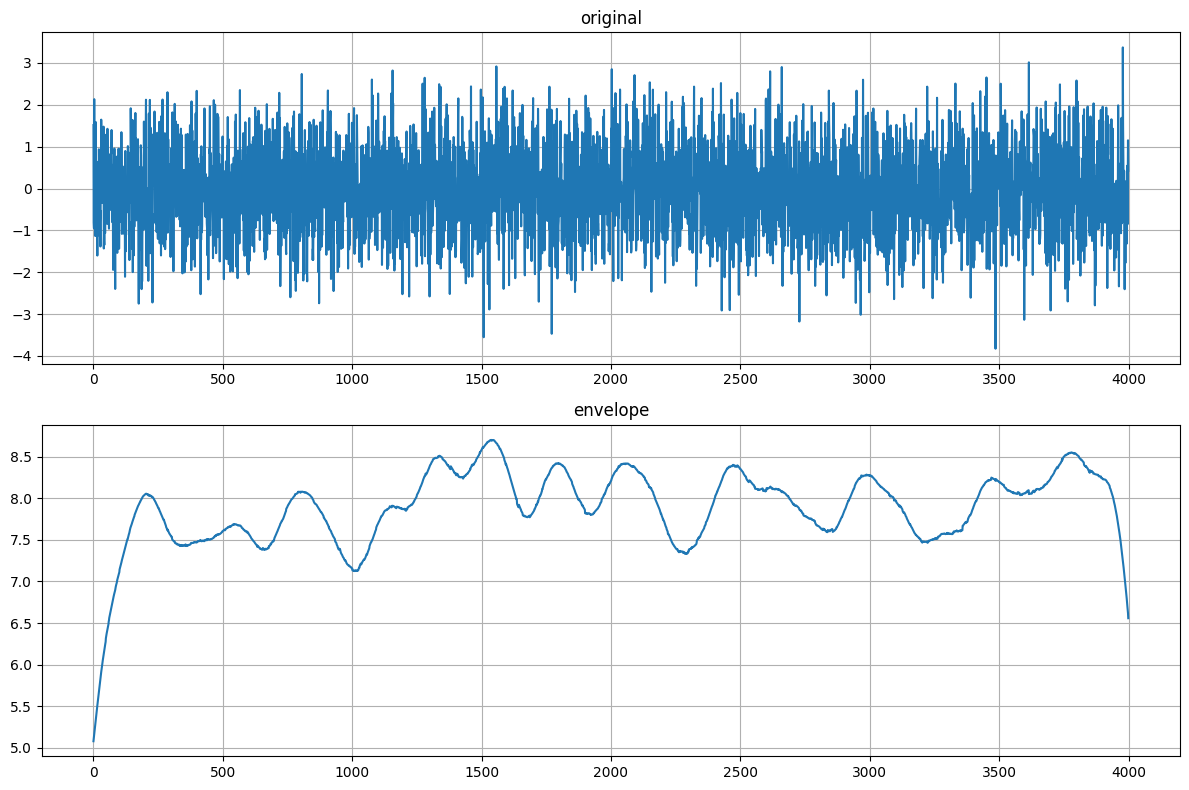

In [11]:
#Data Preprocessing
'''
Input: Signal
Output: Transformed / Augmented data

Envelope Extraction:
https://github.com/scipy/scipy/issues/19634#issuecomment-1873537636

'''

class ArrayPlotter:
    def __init__(self, figsize=(12, 8)):
        self.figsize = figsize

    def plot(self, **kwargs):
        num_plots = len(kwargs)
        rows = int(np.ceil(np.sqrt(num_plots)))
        cols = int(np.ceil(num_plots / rows))

        fig, axs = plt.subplots(rows, cols, figsize=self.figsize)
        axs = axs.flatten() if num_plots > 1 else [axs]

        for i, (name, array) in enumerate(kwargs.items()):
            ax = axs[i]
            ax.plot(array)
            ax.set_title(name)
            ax.grid(True)

        # Remove any unused subplots
        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])

        plt.tight_layout()
        plt.show()


class ProcessSignal:
  '''
  Perform Data Preprocessing
  '''
  def __init__(self)->None:
    pass

  def prefilter(x:np.ndarray, fs:float, cutoff:float)->np.ndarray:
    # Take absolute value
    x_abs = np.abs(x)

    # Design low-pass filter
    normal_cutoff = cutoff / (fs/2)
    b, a = scipy.signal.butter(2, normal_cutoff, btype='low', analog=False)

    return envelope

  def detectEnvelope(self,x:np.ndarray,N:int,fs:float,method = 'rms', window="hamming",prefilter_req=False):
    '''
    return envelope of a desired signal
    '''
    if prefilter_req:
      x=self.prefilter(x,fs,cutoff=0.2)
    x=np.abs(x)
    #Assert that x is a 1D numpy array
    kernel_mapper={"rect":np.ones(N)/N,"hamming":np.hamming(N),"hanning":np.hanning(N),"blackman":np.blackman(N),
                  "gaussian":scipy.signal.windows.gaussian(N,1),"tukey":scipy.signal.windows.tukey(N,1)}
    if method == 'analytic':

      #Calculate the mean of x and remove it
      x_mean = np.mean(x)
      x_zero_mean = x-x_mean

      #Take the absolute value of the Hilbert transform
      #to calculate the analytical envelope of the zero mean
      #version of x
      zero_mean_envelope = np.abs(hilbert(x_zero_mean,N = N))

      #Calculate and return upper and lower envelopes
      return x_mean+zero_mean_envelope,x_mean-zero_mean_envelope

    elif method == 'rms':

      #Assert that N is specified and is an integer
      #For the rms method N serves as window size
      #for the moving average
      assert N and isinstance(N,int), 'N must be an integer'

      #Calculate the mean of x and remove it
      x_mean = np.mean(x)
      x_zero_mean = x-x_mean
      #Moving average is calculated using np.convolve


      #Calculate the RMS envelope of the zero mean version of x.
      kernel=kernel_mapper[window]
      #Moving average is calculated using np.convolve
      zero_mean_envelope = np.sqrt(np.convolve(x_zero_mean**2,kernel,mode = 'same'))

      #Calculate and return upper and lower envelopes
      return x_mean+zero_mean_envelope,x_mean-zero_mean_envelope

    elif method == 'peak':

      #Assert that N is specified and is an integer
      #For the peak method N serves as the minimum number of
      #samples that seperate local maxima
      assert N and isinstance(N,int), 'N must be an integer'

      #Calculate local maxima and minima which will serve
      #as peaks for upper and lower envelopes respectively
      peaks_upper,_ = find_peaks(x,distance = N)
      peaks_lower,_ = find_peaks(-x,distance = N)

      #Calculate upper and lower envelopes by interpolating
      #peaks using a Univariate spline
      upper_spline = UnivariateSpline(peaks_upper,x[peaks_upper])
      lower_spline = UnivariateSpline(peaks_lower,x[peaks_lower])
      upper_envelope = upper_spline(np.arange(x.shape[0]))
      lower_envelope = lower_spline(np.arange(x.shape[0]))

      #Return the envelopes
      return upper_envelope,lower_envelope

    else:

      raise ValueError('%s is not a valid method' %(method))

  def compareSignals(self,original:np.ndarray,signal:np.ndarray,fs:float,arrival_time:float,block:Optional[bool]=True)->None:

    plt.close()
    plt.subplot(2,1,1)
    plt.plot(original)
    plt.subplot(2,1,2)
    plt.plot(signal)
    plt.axvline(x=(arrival_time*fs),color="red")
    plt.show()

  '''
  Test block
  '''
preprocessor=ProcessSignal()
signal=np.random.randn(4000)
envelope=preprocessor.detectEnvelope(signal,N=256,fs=16,method = 'rms', window="hamming",prefilter_req=False)[0]
plotter=ArrayPlotter()
plotter.plot(original=signal,envelope=envelope)

In [12]:
#Dataset
'''
class to assimilate data ,
Input: paths to dataset
Output: Multi-dim matrix,  np.ndarray or torch.tensor
'''
class SeismicDataset:

  def __init__(self,dataset_root:str)->None:
    self.dataset_root=dataset_root
    self.list_of_planets=["lunar","mars"]
    self.modes=["train","test"]
    self.dataset=None
    self.p=ProcessSignal()

  #Deprecated because it causes RAM consumption, use dataloader instead
  def loadDataset(self,pad_seq=False,ohe=False,n_classes:Optional[int]=1)->np.ndarray:
      '''
      dataset of shape (Number of samples, timestamps)
      '''
      signal_stack=[]
      labels=[]
      sampling_rate=[]
      idx_to_lname={}
      for i,row in self.dataset.iterrows():
        filename=row["filename"]
        logname=row["logname"]
        try:
          time_rel=row["time_rel(sec)"]
        except:
          time_rel=-1
        signal = obspy.read(filename + ".mseed")
        fs=signal[0].stats.sampling_rate
        print(fs)
        e=self.p.detectEnvelope(signal[0].data,int(fs*512),'rms',"hamming",True)[0]
        assert max(e.shape)==max(signal[0].data.shape)
        s=obspy.Trace(e)
        s.stats.sampling_rate=fs
        s.resample(FS_MARS)

        signal_stack.append(s.data)
        fs=FS
        labels.append(time_rel)
        sampling_rate.append(fs)
        idx_to_lname[i]=logname
      if pad_seq:
        signal_stack=self.padSequences(signal_stack)
      if ohe:
        labels=self.one_hot_encode(labels,n_classes)
      return signal_stack, labels, sampling_rate, idx_to_lname

  def loadTestset(self,pad_seq=False)->np.ndarray:
      '''
      dataset of shape (Number of samples, timestamps)
      '''
      signal_stack=[]
      sampling_rate=[]

      for i,row in self.testset.iterrows():
        filename=row["filename"]
        signal = obspy.read(filename + ".mseed")
        signal_stack.append(signal[0].data)
        sampling_rate.append(signal[0].stats.sampling_rate)
      if pad_seq:
        signal_stack=self.padSequences(signal_stack)
      return signal_stack, sampling_rate

  def loadPredictions(self, predicted):
      '''
      dataset of shape (Number of samples)
      '''
      filename = []
      for i,row in self.testset.iterrows():
        filename.append(row["filename"])
      df = pd.DataFrame(filename, columns=['Filename'])
      df['prediction'] = predicted
      # TODO convert predicted time slot to an Absolute (or relative?) time

      return df

  def one_hot_encode(self,array:np.ndarray, num_classes:int):
    # Create a zero array of shape (array_len, num_classes)
    n_samples=len(array)
    sample_hist={}
    for sample in train_data:
      maxlen=max(sample.shape)
      if maxlen not in sample_hist.keys():
        sample_hist[maxlen]=1
      else:
        sample_hist[maxlen]+=1

    maxlen=max(sample_hist.keys())

    one_hot = np.zeros((n_samples,maxlen))

    # Use NumPy's advanced indexing to place 1s
    one_hot[:,np.array(array,dtype=np.uint32)] = 1
    return one_hot

  def padSequences(self,train_data):

    sample_hist={}
    for sample in train_data:
      maxlen=max(sample.shape)
      if maxlen not in sample_hist.keys():
        sample_hist[maxlen]=1
      else:
        sample_hist[maxlen]+=1

    x_train=np.zeros((len(train_data),maxlen))
    for i,xsample in enumerate(train_data):
      clen=len(xsample)
      x_train[i,:clen]=xsample[:clen]
    return x_train

  def generatePathToLogs(self,mode:Literal["train","test"],planet:Literal["lunar","mars"],split:float=0.8)->None:
    '''
    returns a DataFrame with columns: filename,logname,time_rel(label)
    split: percent of actual train data from train data, rest goes to validation
    '''
    # Extract Catalog for time_rel aka label data
    mode_orig=mode
    mode = "train" if mode in ["train","valid"] else "test"
    if mode in ["train","valid"]:
      mode="train"
      rel_path_to_cat=planet+"/catalog"
      database_roots={"catalog":
                      {
                      planet:
                      {mode:rel_path_to_cat,}
                      }
                    }

      list_of_csvs_path=[]
      for planet_data in database_roots.values():
        for planet,data_cap in planet_data.items():
          for data_category,path in data_cap.items():
            path1=os.path.join(self.dataset_root,path)
            list_dirs=os.listdir(path1)
            for csvpath in list_dirs:
                path2=os.path.join(path1,csvpath)
                assert os.path.isfile(path2), "Path not found"
                list_of_csvs_path.append(path2)

      catalog=[]

      for csv_path in list_of_csvs_path:
        df=pd.read_csv(csv_path)
        df["logname"]=df["filename"].apply(lambda name: name.strip(".csv").strip(".mseed"))
        df.name="_".join(csv_path.split("/")[1:3])
        catalog.append(df)

      del list_of_csvs_path
      if len(catalog)>1:
        catalog=pd.concat(catalog)
        catalog.reset_index(drop=True, inplace=True)


      #Signal extraction
      rel_path_to_data=planet+"/"+mode
      database_roots={"data":
                    {planet:
                    {mode:rel_path_to_data},
                    }
                  }
      list_of_csvs=[]

      for planet_data in database_roots.values():
          for planet,data_cap in planet_data.items():
              for data_category,path in data_cap.items():
                  path1=os.path.join(self.dataset_root,path)

                  scandir=os.scandir(path1)
                  respaths=[]
                  lognames=[]
                  for sample in scandir:

                    res_path=os.path.join(path1,sample.name.strip(".csv").strip(".mseed"))
                    log_name=sample.name.strip(".csv").strip(".mseed")

                    respaths.append(res_path)
                    lognames.append(log_name)

                  df=pd.DataFrame({"filename":respaths,"logname":lognames})
                  df.attrs["metadata"]={"name":planet,"type":data_category}

                  list_of_csvs.append(df)
                  del df

      signals_table=list_of_csvs[0]
      del list_of_csvs

      training_data=pd.merge(signals_table,catalog, on='logname')
      training_data=training_data.drop(columns=["filename_y"])
      training_data=training_data.rename(columns={"filename_x":"filename"})
      print(catalog["logname"],"HERE")
      print(signals_table["logname"],"HERE")
      self.dataset=training_data.copy()
      if mode_orig=="valid":
        n_rows_to_drop = int(self.dataset.shape[0] * split)
        # Drop the first split percent of rows
        self.dataset = self.dataset.iloc[n_rows_to_drop:].reset_index(drop=True)

    elif mode=="test":
      #Signal extraction
      rel_path_to_data=planet+"/"+mode
      database_roots={"data":
                    {planet:
                    {mode:rel_path_to_data},
                    }
                  }
      list_of_csvs=[]

      for planet_data in database_roots.values():
          for planet,data_cap in planet_data.items():
              for data_category,path in data_cap.items():
                  path1=os.path.join(self.dataset_root,path)

                  scandir=os.scandir(path1)
                  respaths=[]
                  lognames=[]
                  for sample in scandir:

                    res_path=os.path.join(path1,sample.name.strip(".csv").strip(".mseed"))
                    log_name=sample.name.strip(".csv").strip(".mseed")
                    respaths.append(res_path)
                    lognames.append(log_name)

                  df=pd.DataFrame({"filename":respaths,"logname":lognames})
                  df.attrs["metadata"]={"name":planet,"type":data_category}

                  list_of_csvs.append(df)
                  del df

      signals_table=list_of_csvs[0]
      self.dataset=signals_table.copy()

      del list_of_csvs
      del signals_table

    gc.collect()

'''
Test block
'''
dataTester=SeismicDataset(DATASET_ROOT_PATH)
dataTester.generatePathToLogs(mode="train",planet="mars")
train_data,train_labels,sampling_rate,idx_to_lname_train=dataTester.loadDataset(pad_seq=True)


0       XB.ELYSE.02.BHV.2022-02-03HR08_evid0005
1       XB.ELYSE.02.BHV.2022-01-02HR04_evid0006
2    XB.ELYSE.02.BHV.M.2022.034.080000_evid0005
3    XB.ELYSE.02.BHV.M.2022.002.040000_evid0006
Name: logname, dtype: object HERE
0    XB.ELYSE.02.BHV.2022-02-03HR08_evid0005
1    XB.ELYSE.02.BHV.2022-01-02HR04_evid0006
Name: logname, dtype: object HERE


FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.10/dist-packages/scipy-1.13.1.dist-info/METADATA'

In [ ]:
dataTester.generatePathToLogs(mode="test",planet="mars")
test_data,test_labels,sampling_rate,idx_to_lname_test=dataTester.loadDataset(pad_seq=True)

In [ ]:

#Dataset
'''
PyTorch DataLoader
'''
def custom_collate(batch):
    #snippets, labels, labels_b = zip(*batch)
    snippets=batch
    snippets_padded = pad_sequence(snippets, batch_first=True)
    snippets_padded = torch.squeeze(snippets_padded)
    snippets_padded = torch.unsqueeze(snippets_padded, 2)
    """labels = torch.tensor(np.array(labels))
    labels = torch.squeeze(labels)
    labels_b = torch.tensor(np.array(labels_b))
    labels_b = torch.squeeze(labels_b)"""
    return snippets_padded

MAX_SEQ_LEN=max(float('-inf'),572400)

class SeismicDataloader(torch.utils.data.Dataset):
    def __init__(self,window_size:int,*args, **kwargs):
        super().__init__()

        global MAX_SEQ_LEN

        dataTester=SeismicDataset(DATASET_ROOT_PATH)
        dataTester.generatePathToLogs(**kwargs)

        mode = kwargs.get("mode")
        self.dataset_map=dataTester.dataset.copy()


        """for i,row in self.dataset_map.iterrows():
          filename=row["filename"]
          if mode != "test":
            time_rel=row["time_rel(sec)"]
          signal = np.array(obspy.read(filename + ".mseed"))
          if MAX_SEQ_LEN < max(signal.shape):
            MAX_SEQ_LEN = max(signal.shape)
          del signal
        MAX_SEQ_LEN=int(MAX_SEQ_LEN/100)*100
        print(MAX_SEQ_LEN)"""

        n_samples=self.dataset_map.shape[0]
        self.length=n_samples*MAX_SEQ_LEN//window_size
        print(self.length)
        # Initialize other attributes or data loading processes here
        self.current_signal=None
        self.idx_tracker=0
        self.max_seq_len=MAX_SEQ_LEN
        self.window_size=window_size

    def __len__(self):
        # Implement length method
        return self.length

    def __getitem__(self, index):

        offset=index*self.window_size
        self.idx_tracker=offset//self.max_seq_len

        filename, label = self.dataset_map.iloc[self.idx_tracker][["filename", "time_rel(sec)"]]
        signal = obspy.read(filename + ".mseed")[0].data

        self.current_signal = np.array(signal).reshape(1,-1)

        start = offset-self.idx_tracker * self.max_seq_len
        end = start + self.window_size

        snippet = self.current_signal[:,start:end]

        if snippet.shape[1] < self.window_size:
          padding_width = self.window_size - snippet.shape[1]
          snippet = np.pad(snippet, ((0, 0), (0, padding_width)), mode='constant', constant_values=0)


        if end > self.current_signal.shape[0]:
            self.current_signal = None

        label_ohe = np.zeros((1,self.window_size))
        label_b=np.array([0])
        if label > start and label < end:
            label_ohe[:,int(label - start)] = 1
            label_b[0]=1
        snippet = np.expand_dims(snippet, axis=0)
        snippet = torch.tensor(snippet, dtype=torch.float32)
        label_ohe = torch.tensor(label_ohe,dtype=torch.float32)
        label_b = torch.tensor(label_b,dtype=torch.float32)

        return snippet

In [ ]:
'''
Dataloader, filewise sampling
'''
def get_sub_seqs(x_arr, seq_len=100, stride=1):
    """

    Parameters
    ----------
    x_arr: np.array, required
        input original data with shape [time_length, channels]

    seq_len: int, optional (default=100)
        Size of window used to create subsequences from the data

    stride: int, optional (default=1)
        number of time points the window will move between two subsequences

    Returns
    -------
    x_seqs: np.array
        Split sub-sequences of input time-series data
    """

    if x_arr.shape[0] < seq_len:
        seq_len = x_arr.shape[0]
    seq_starts = np.arange(0, x_arr.shape[0] - seq_len + 1, stride)
    x_seqs = np.array([x_arr[i:i + seq_len] for i in seq_starts])

    return x_seqs

def custom_collate(batch):
    #snippets, labels, labels_b = zip(*batch)
    snippets=batch
    snippets_padded = pad_sequence(snippets, batch_first=True)
    snippets_padded = torch.squeeze(snippets_padded)
    """labels = torch.tensor(np.array(labels))
    labels = torch.squeeze(labels)
    labels_b = torch.tensor(np.array(labels_b))
    labels_b = torch.squeeze(labels_b)"""
    return snippets_padded

MAX_SEQ_LEN=max(float('-inf'),572400)

class SeismicDataloaderV2(torch.utils.data.Dataset):
    def __init__(self,window_size:int,seqlen:int,*args, **kwargs):
        super().__init__()

        global MAX_SEQ_LEN

        dataTester=SeismicDataset(DATASET_ROOT_PATH)
        dataTester.generatePathToLogs(**kwargs)

        mode = kwargs.get("mode")
        self.seqlen=seqlen
        self.dataset_map=dataTester.dataset.copy()


        """for i,row in self.dataset_map.iterrows():
          filename=row["filename"]
          if mode != "test":
            time_rel=row["time_rel(sec)"]
          signal = np.array(obspy.read(filename + ".mseed"))
          if MAX_SEQ_LEN < max(signal.shape):
            MAX_SEQ_LEN = max(signal.shape)
          del signal
        MAX_SEQ_LEN=int(MAX_SEQ_LEN/100)*100
        print(MAX_SEQ_LEN)"""

        n_samples=self.dataset_map.shape[0]
        self.length=n_samples
        # Initialize other attributes or data loading processes here
        self.current_signal=None
        self.idx_tracker=0
        self.max_seq_len=MAX_SEQ_LEN
        self.window_size=window_size

    def __len__(self):
        # Implement length method
        return self.length

    def __getitem__(self, index):



        filename, label = self.dataset_map.iloc[index][["filename", "time_rel(sec)"]]
        signal = obspy.read(filename + ".mseed")[0].data

        self.current_signal = np.array(signal).reshape(1,-1)
        nsamples=self.current_signal.shape[1]

        stride=(nsamples-self.window_size)//(self.seqlen-1)

        self.current_signal = get_sub_seqs(self.current_signal.T, seq_len=self.window_size, stride=stride)

        snippet = torch.tensor(self.current_signal)

        return snippet

In [ ]:
mydataloader=SeismicDataloaderV2(window_size=30000,seqlen=100,mode="train",planet="lunar")
dataloader=DataLoader(mydataloader,batch_size=8,shuffle=True,collate_fn=custom_collate)

for i,snippets in enumerate(dataloader):
  print(snippets.shape)

In [ ]:
from torch.utils.data import DataLoader
mydataloader=SeismicDataloaderV2(window_size=30000,seqlen=100,mode="train",planet="lunar")

# Create DataLoader with batch size
data_loader = DataLoader(mydataloader, batch_size=8, shuffle=True,collate_fn=custom_collate)
pos_class=0
# Iterate through the data loader to get batches
for i, snippets in enumerate(data_loader):
  print(snippets.shape)

In [ ]:
# @title Anomaly Detector
"""Primitive Anomaly Transformer

This primitive is an pytorch implementation of "Anomaly Transformer:
Time Series Anomaly Detection with Association Discrepancy"
https://arxiv.org/pdf/2110.02642.pdf

This is a modified version of the original code, which can be found
at https://github.com/thuml/Anomaly-Transformer/tree/main
"""
# -*- coding: utf-8 -*-

import logging
import math
import operator
import os
from itertools import groupby
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from mlstars.utils import import_object
from torch.utils.data import DataLoader

from orion.primitives.timeseries_anomalies import _merge_sequences, _prune_anomalies

LOGGER = logging.getLogger(__name__)


class Signal(object):
    """Data object.

    Args:
        X (ndarray):
            An n-dimensional array of signal values.
        window_size (int):
            Size of the window.
        step (int):
            Stride size.
    """

    def __init__(self, X, window_size, step=1, mode='train'):
        self.data = X
        self.step = step
        self.mode = mode
        self.window_size = window_size

    def __len__(self):
        if self.mode == 'test':
            return (self.data.shape[0] - self.window_size) // self.window_size + 1

        return (self.data.shape[0] - self.window_size) // self.step + 1

    def __getitem__(self, index):
        start = index * self.step
        end = start + self.window_size

        if self.mode == 'train':
            return np.float32(self.data[start: end])
        elif self.mode == 'test':
            start = start // self.step * self.window_size
            return np.float32(self.data[start: start + self.window_size])
        else:
            raise ValueError(f'Unknown {self.mode} mode.')


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, input_size, d_model):
        super(TokenEmbedding, self).__init__()

        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=input_size, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular',
                                   bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        return self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)


class DataEmbedding(nn.Module):
    def __init__(self, input_size, d_model, dropout=0.0):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(input_size=input_size, d_model=d_model)
        self.position_encoding = PositionalEncoding(d_model=d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.value_embedding(x) + self.position_encoding(x)
        return self.dropout(x)


class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool),
                                    diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask


class AnomalyAttention(nn.Module):
    def __init__(self, window_size, mask_flag=True, scale=None, attention_dropout=0.0,
                 output_attention=False, device="cpu"):
        super(AnomalyAttention, self).__init__()

        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.device = device
        self.dropout = nn.Dropout(attention_dropout)
        self.distances = torch.zeros((window_size, window_size)).to(device)
        for i in range(window_size):
            for j in range(window_size):
                self.distances[i][j] = abs(i - j)

    def forward(self, queries, keys, values, sigma, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / math.sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        attn = scale * scores
        sigma = sigma.transpose(1, 2)  # B L H ->  B H L
        window_size = attn.shape[-1]
        sigma = torch.sigmoid(sigma * 5) + 1e-5
        sigma = torch.pow(3, sigma) - 1
        sigma = sigma.unsqueeze(-1).repeat(1, 1, 1, window_size)  # B H L L
        prior = self.distances.unsqueeze(0).unsqueeze(0).repeat(
            sigma.shape[0], sigma.shape[1], 1, 1).to(self.device)

        prior = 1.0 / (math.sqrt(2 * math.pi) * sigma) * torch.exp(-prior ** 2 / 2 / (sigma ** 2))

        series = self.dropout(torch.softmax(attn, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", series, values)

        if self.output_attention:
            return (V.contiguous(), series, prior, sigma)
        else:
            return (V.contiguous(), None)


class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, num_heads, d_keys=None, d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // num_heads)
        d_values = d_values or (d_model // num_heads)
        self.norm = nn.LayerNorm(d_model)
        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * num_heads)
        self.key_projection = nn.Linear(d_model, d_keys * num_heads)
        self.value_projection = nn.Linear(d_model, d_values * num_heads)
        self.sigma_projection = nn.Linear(d_model, num_heads)
        self.out_projection = nn.Linear(d_values * num_heads, d_model)

        self.num_heads = num_heads

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.num_heads
        x = queries
        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)
        sigma = self.sigma_projection(x).view(B, L, H)

        out, series, prior, sigma = self.inner_attention(
            queries,
            keys,
            values,
            sigma,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), series, prior, sigma


class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, n_hidden=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()

        n_hidden = n_hidden or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=n_hidden, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=n_hidden, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        new_x, attn, mask, sigma = self.attention(
            x, x, x,
            attn_mask=attn_mask
        )
        x = x + self.dropout(new_x)
        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn, mask, sigma


class Encoder(nn.Module):
    def __init__(self, attn_layers, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        series_list = []
        prior_list = []
        sigma_list = []
        for attn_layer in self.attn_layers:
            x, series, prior, sigma = attn_layer(x, attn_mask=attn_mask)
            series_list.append(series)
            prior_list.append(prior)
            sigma_list.append(sigma)

        if self.norm is not None:
            x = self.norm(x)

        return x, series_list, prior_list, sigma_list


class ATModel(nn.Module):
    def __init__(self, window_size, input_size, output_size, d_model=512, num_heads=8,
                 num_layers=3, n_hidden=512, dropout=0.0, activation='gelu',
                 output_attention=True, attention_dropout=0.0, device="cpu"):
        super(ATModel, self).__init__()
        self.output_attention = output_attention

        # Embedding
        self.embedding = DataEmbedding(input_size, d_model, dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        AnomalyAttention(
                            window_size=window_size, mask_flag=False, scale=None,
                            attention_dropout=attention_dropout, output_attention=output_attention,
                            device=device
                        ),
                        d_model=d_model, num_heads=num_heads
                    ),
                    d_model=d_model,
                    n_hidden=n_hidden,
                    dropout=dropout,
                    activation=activation
                ) for _ in range(num_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )

        self.projection = nn.Linear(d_model, output_size, bias=True)

    def forward(self, x):
        enc_out = self.embedding(x)
        enc_out, series, prior, sigmas = self.encoder(enc_out)
        enc_out = self.projection(enc_out)

        if self.output_attention:
            return enc_out, series, prior, sigmas
        else:
            return enc_out  # [B, L, D]


class AnomalyTransformer():
    """Anomaly Transformer model for unsupervised time series anomaly detection.

    Args:
        window_size (int):
            Window size of each sample.
        step (int):
            Stride size between samples.
        unit (str):
            String representing the unit of timestamps.
        interval (int):
            The time gap between one sample and another.
        input_size (int):
            Input size for the network.
        output_size (int):
            Output size for the network.
        d_model (int):
            Model dimension.
        n_hidden (int):
            Hidden dimension.
        batch_size (int):
            Number of example per epoch.
        dropout (float):
            Dropout value of the network.
        attention_dropout (float):
            Dropout value for attention.
        epochs (int):
            Number of iterations to train the model.
        learning_rate (float):
            Learning rate for the optimizer.
        temperature (int):
            Scaling value. Default 50.
        verbose (bool):
            Whether to be on verbose mode or not.
        cuda (bool):
            Whether to use GPU or not.
        valid_split (float):
            A float to split data dataframe to validation set. Data needs to contain a label
            column. Use ``target_column`` to change the target column name.
        output_dir (str):
            Path to folder where to save the model.
    """
    @staticmethod
    def _kl_loss(p, q):
        res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
        return torch.mean(torch.sum(res, dim=-1), dim=1)

    @staticmethod
    def _adjust_learning_rate(optimizer, epoch, lr_):
        lr_adjust = {epoch: lr_ * (0.5 ** ((epoch - 1) // 1))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            LOGGER.info(f'Updating learning rate to {lr}')

    def __init__(self, input_size=1, output_size=1, window_size=100, step=1, k=3, d_model=512,
                 n_hidden=512, num_layers=3, num_heads=8, attention_dropout=0.0, dropout=0.0,
                 activation='gelu', output_attention=True, batch_size=256, learning_rate=1e-4,
                 temperature=50, epochs=10, valid_split=0.0, shuffle=True, cuda=True,
                 optimizer="torch.optim.Adam", verbose=False, output_dir=False):

        self.input_size = input_size
        self.output_size = output_size
        self.window_size = window_size
        self.step = step

        self.k = k
        self.d_model = d_model
        self.n_hidden = n_hidden
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dropout = dropout
        self.activation = activation
        self.output_attention = output_attention
        self.attention_dropout = attention_dropout

        self.temperature = temperature
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.valid_split = valid_split
        self.shuffle = shuffle
        self.cuda = cuda
        self.verbose = verbose
        self.output_dir = output_dir

        self.device = "cpu"
        if cuda and torch.cuda.is_available():
            self.device = "cuda"

        # build model
        self.model = ATModel(
            window_size=self.window_size,
            input_size=self.input_size,
            output_size=self.output_size,
            d_model=self.d_model,
            num_heads=self.num_heads,
            num_layers=self.num_layers,
            n_hidden=self.n_hidden,
            dropout=self.dropout,
            activation=self.activation,
            output_attention=self.output_attention,
            attention_dropout=self.attention_dropout,
            device=self.device
        )

        self.optimizer = import_object(optimizer)(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        self.mse = nn.MSELoss(reduce=False)
        self.model.to(self.device)

    def _get_loss(self, prior, series, temperature=1, detach=False):
        # calculate Association discrepancy
        series_loss = 0.0
        prior_loss = 0.0
        for u in range(len(prior)):
            series_value = series[u]
            prior_value = prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1),
                                                     dim=-1).repeat(1, 1, 1, self.window_size)

            series_second = series_value
            prior_second = prior_value

            if detach:
                series_second = series_second.detach()
                prior_second = prior_second.detach()

            series_loss += (
                torch.mean(self._kl_loss(series_second, prior_value.detach()))
                + torch.mean(self._kl_loss(prior_value.detach(), series_second))
            ) * temperature

            prior_loss += (
                torch.mean(self._kl_loss(prior_second, series_value.detach()))
                + torch.mean(self._kl_loss(series_value.detach(), prior_second))
            ) * temperature

        return series_loss, prior_loss

    def _get_energy(self, data_loader):
        self.model.eval()

        energy = []
        predictions = []
        for i, input_data in enumerate(data_loader):
            x = input_data.to(self.device)
            output, series, prior, _ = self.model(x)
            predictions.append(output.detach().cpu().numpy())
            loss = torch.mean(self.mse(x, output), dim=-1)
            series_loss, prior_loss = self._get_loss(
                prior, series, temperature=self.temperature, detach=True)

            metric = torch.softmax((-series_loss - prior_loss), dim=-1)
            energy.append((metric * loss).detach().cpu().numpy())

        return np.concatenate(energy, axis=0), np.concatenate(predictions, axis=0)

    def _validate(self, valid_loader):
        self.model.eval()

        losses = list()
        for input_data in valid_loader:
            x = input_data.to(self.device)
            output, series, prior, _ = self.model(x)

            series_loss, _ = self._get_loss(prior, series)
            series_loss = series_loss / len(prior)
            rec_loss = self.criterion(output, x)

            losses.append((rec_loss - self.k * series_loss).item())

        return np.mean(losses)

    def _fit(self, train_loader, valid_loader):
        loss_dict={}
        for epoch in range(self.epochs):
            losses = []
            self.model.train()

            for input_data in train_loader:
                self.optimizer.zero_grad()
                x = input_data.to(self.device)
                output, series, prior, _ = self.model(x)

                series_loss, prior_loss = self._get_loss(prior, series)
                series_loss = series_loss / len(prior)
                prior_loss = prior_loss / len(prior)

                rec_loss = self.criterion(output, x)

                losses.append((rec_loss - self.k * series_loss).item())
                rec_series_loss = rec_loss - self.k * series_loss
                rec_prior_loss = rec_loss + self.k * prior_loss

                # minimax strategy
                rec_series_loss.backward(retain_graph=True)
                rec_prior_loss.backward()
                self.optimizer.step()

            if valid_loader is not None:
                valid_loss = self._validate(valid_loader)
            else:
                valid_loss = None

            if self.verbose:
                print('Epoch: {}/{}, Loss: {}, Valid Loss {}'.format(
                    epoch + 1, self.epochs, np.mean(losses), valid_loss))

            self._adjust_learning_rate(self.optimizer, epoch + 1, self.learning_rate)
            loss_dict[epoch]=losses
        self.loss_dict=loss_dict

    def fit(self, X):
        train = X
        valid_loader = None

        # split data
        if self.valid_split > 0:
            valid_size = int(len(X) * self.valid_split)
            train = X[: -valid_size]
            valid = X[-valid_size:]

            valid_loader = DataLoader(dataset=Signal(valid, self.window_size, self.step),
                                      batch_size=self.batch_size,
                                      shuffle=False)

        train_loader = DataLoader(dataset=Signal(train, self.window_size, self.step),
                                  batch_size=self.batch_size,
                                  shuffle=self.shuffle)

        self._fit(train_loader, valid_loader)

        if self.output_dir:
            model_dir = Path(self.output_dir)
            os.makedirs(model_dir, exist_ok=True)
            LOGGER.info(f"Saving model to {model_dir}.")
            torch.save(self.model.state_dict(), model_dir + f'checkpoint_{self.epochs}.pth')

        self.train_energy, train_predictions = self._get_energy(train_loader)

    def predict(self, X):
        data_loader = DataLoader(dataset=Signal(X, self.window_size, self.step, mode='test'),
                                 batch_size=self.batch_size)

        energy, predictions = self._get_energy(data_loader)
        return predictions, energy, self.train_energy


def threshold_anomalies(energy, index, train_energy, anomaly_ratio=1.0, min_percent=0.1,
                        anomaly_padding=50):
    energy = np.array(energy.reshape(-1))
    train_energy = np.array(train_energy.reshape(-1))
    combined_energy = np.concatenate([train_energy, energy], axis=0)
    thresh = np.percentile(combined_energy, 100 - anomaly_ratio)

    anomalies = (energy > thresh).astype(int)

    intervals = list()
    idx = 0
    for is_anomaly, g in groupby(anomalies):
        length = len(list(g))
        if is_anomaly == 1:
            start = max(0, idx - anomaly_padding)
            end = min(idx + length + anomaly_padding, len(anomalies)) - 1
            intervals.append((index[start], index[end], np.mean(energy[start: end + 1])))

        idx += length

    intervals.sort(key=operator.itemgetter(2), reverse=True)
    intervals = pd.DataFrame.from_records(intervals, columns=['start', 'stop', 'max_error'])

    pruned = _prune_anomalies(intervals, min_percent)
    return _merge_sequences(pruned)

In [ ]:
# @title Default title text
x_train=np.array(train_data)
at=AnomalyTransformer(batch_size=32,window_size=256,step=256//2)
at.fit(x_train.reshape(1,-1).T)

In [ ]:
%pip install orion-ml

INFO: pip is looking at multiple versions of pyts to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.6/145.6 kB 14.0 MB/s 

In [ ]:
from orion.data import load_signal

def build_df(data, start=0):

    index = np.array(range(start, start + len(data)))
    timestamp = index * 21600 + 1222819200
    print(data.shape)
    return pd.DataFrame({'timestamp': timestamp, 'value': data[:, 0]})

x_train, y_train = np.array(train_data), np.array(train_labels)
print(x_train.shape)
train_data=np.expand_dims(x_train[0,:],axis=0).T
train_data = build_df(train_data, start=0)
train_data

(2, 21600)
(21600, 1)


,timestamp,value
0,1222819200,4200.392308
1,1222840800,4271.907498
2,1222862400,4257.338108
3,1222884000,4269.528260
4,1222905600,4264.632233
...,...,...
21595,1689271200,4102.814952
21596,1689292800,4106.169436
21597,1689314400,4097.580039
21598,1689336000,4105.169541


In [ ]:


from orion import Orion

hyperparameters = {
    'orion.primitives.aer.AER#1': {
        'epochs': 10,
        'verbose': True
    }
}

orion = Orion(
    pipeline='aer',
    hyperparameters=hyperparameters
)

orion.fit(train_data)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:356: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(


Epoch 1/10
269/269 [==============================] - 30s 85ms/step - loss: 0.0092 - tf.__operators__.getitem_9_loss: 0.0128 - tf.__operators__.getitem_10_loss: 0.0070 - tf.__operators__.getitem_11_loss: 0.0101 - val_loss: 5.6811e-04 - val_tf.__operators__.getitem_9_loss: 4.7880e-04 - val_tf.__operators__.getitem_10_loss: 4.8885e-04 - val_tf.__operators__.getitem_11_loss: 8.1595e-04
Epoch 2/10
269/269 [==============================] - 21s 79ms/step - loss: 2.8507e-04 - tf.__operators__.getitem_9_loss: 2.2844e-04 - tf.__operators__.getitem_10_loss: 3.2224e-04 - tf.__operators__.getitem_11_loss: 2.6733e-04 - val_loss: 1.4158e-04 - val_tf.__operators__.getitem_9_loss: 6.4570e-05 - val_tf.__operators__.getitem_10_loss: 1.1355e-04 - val_tf.__operators__.getitem_11_loss: 2.7465e-04
Epoch 3/10
269/269 [==============================] - 21s 79ms/step - loss: 1.3288e-04 - tf.__operators__.getitem_9_loss: 7.6703e-05 - tf.__operators__.getitem_10_loss: 1.7884e-04 - tf.__operators__.getitem_11_lo

In [ ]:
x_test= np.array(test_data)
print(x_test.shape)
index_to_timestamp={}
for ch in range(x_test.shape[0]):
  print("doing ", ch)
  new_data = x_test[ch,:].reshape(1,-1).T
  new_data = build_df(new_data, start=0)
  anomalies = orion.detect(new_data)
  anomalies=anomalies.sort_values(by='severity',ascending=False)
  try:
    timestamp_start=np.array(anomalies["start"].iloc[0])
  except:
    timestamp_start=-1
  index= (timestamp_start - 1222819200)//21600
  index_to_timestamp[ch]=float(index)*ORIG_FS_MARS/FS_MARS


(9, 21600)
doing  0
(21600, 1)
672/672 [==============================] - 7s 10ms/step
doing  1
(21600, 1)
672/672 [==============================] - 7s 10ms/step
doing  2
(21600, 1)
672/672 [==============================] - 7s 10ms/step
doing  3
(21600, 1)
672/672 [==============================] - 7s 10ms/step
doing  4
(21600, 1)
672/672 [==============================] - 7s 10ms/step
doing  5
(21600, 1)
672/672 [==============================] - 7s 10ms/step
doing  6
(21600, 1)
672/672 [==============================] - 7s 10ms/step
doing  7
(21600, 1)
672/672 [==============================] - 7s 10ms/step
doing  8
(21600, 1)
672/672 [==============================] - 7s 10ms/step


In [ ]:
!rm -rf images/

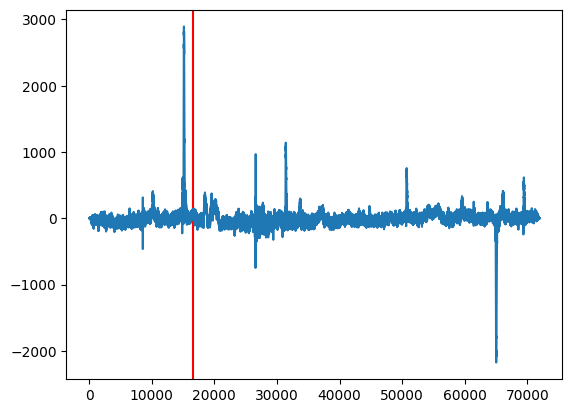

In [ ]:
for idx,ts in index_to_timestamp.items():
  plt.close()
  logname=idx_to_lname_test[idx]
  signal=np.array(obspy.read("data/mars/test/"+logname+".mseed")[0].data)
  plt.axvline(x=ts,color='r')
  plt.plot(signal)
  plt.savefig("images/"+logname+".png")

Text(0.5, 1.0, 'XB.ELYSE.02.BHV.2022-05-04HR23_evid0001')

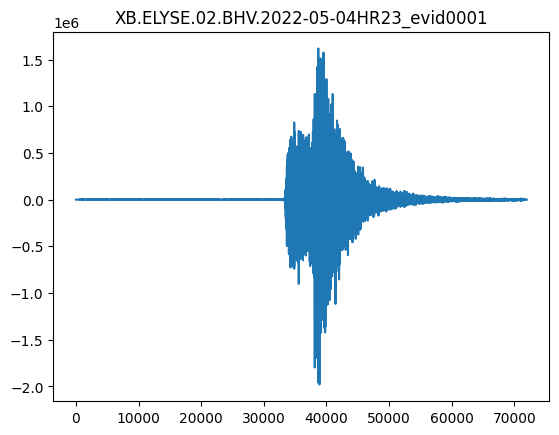

In [ ]:
idx=0
ts=index_to_timestamp[idx]
plt.close()
logname=idx_to_lname_test[idx]
signal=np.array(obspy.read("data/mars/test/"+logname+".mseed")[0].data)
#plt.axvline(x=ts,color='r')
plt.plot(signal)
plt.title(logname)


In [ ]:
!tar -czvf images.tar.gz images/

images/
images/XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.png
images/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.png
images/XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.png
images/XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.png
images/XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.png
images/XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.png
images/XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.png
images/XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.png
images/XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.png


In [ ]:
lognames=idx_to_lname_test.values()
timerels=index_to_timestamp.values()
df=pd.DataFrame({"filename":lognames,"time_rel(sec)":timerels})
df.to_csv("test_results_mars.csv")

In [ ]:
# Assume AnomalyTransformer contains a model attribute
# Check and save the internal model state
v=str(2)
anomaly_transformer = at
if hasattr(anomaly_transformer, 'model'):
    torch.save(anomaly_transformer.model.state_dict(), f"{output_dir}/model_v"+v+".pth")
else:
    print("The attribute 'model' does not exist within 'AnomalyTransformer'.")

# For other components inside it, handle individually
# Example for optimizer if it has one
if hasattr(anomaly_transformer, 'optimizer'):
    torch.save(anomaly_transformer.optimizer.state_dict(), f"{output_dir}/optimizer.pth")
else:
    print("The attribute 'optimizer' does not exist within 'AnomalyTransformer'.")

In [ ]:
#RELOAD MODEL

output_dir = 'model_env'  # The directory where you saved the model
model=AnomalyTransformer()
# Load the state_dict into your model
model.load_state_dict(torch.load(f"{output_dir}/model.pth"))

# If you saved the optimizer state, reload it similarly
optimizer = ...  # Define your optimizer here
optimizer.load_state_dict(torch.load(f"{output_dir}/optimizer.pth"))

# Set the model to evaluation mode (if needed)
model.eval()

print("Model and optimizer loaded successfully.")

In [ ]:
def convert_to_batches_of_data(data,batches):

  nsamples,ntimestamps=data.shape
  data=data[:,:int(ntimestamps/batches)*batches]

  data=data.reshape(nsamples,int(ntimestamps/batches),batches)
  data=data.reshape(nsamples*int(ntimestamps/batches),-1)

  return data
x_input=convert_to_batches_of_data(x_train,100)
y_input=convert_to_batches_of_data(y_train,100)

In [ ]:
# SeismicModel and dependencies

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, KLDivergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from SeismicModel import SeismicModel

2024-10-06 07:47:49.822937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 07:47:49.822998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 07:47:49.824261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 07:47:49.830030: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Model Definition
'''
Define model architectures
Input: tensor signal
Output: binary signal
'''
x = np.swapaxes(x_input, 1, 0)
print(x.shape)
y = np.swapaxes(y_input, 1, 0)
print(y.shape)


(100, 429300)
(100, 429300)


In [ ]:
#x = np.zeros((N,min_len))
#for idx in range(len(train_data[:])):
#    x[idx] = train_data[idx][:min_len]
#print(x.shape)

seismic_model = SeismicModel(name="vae-mlp")
seismic_model.SetTrain(x, y)
seismic_model.BuildModel()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 429300)]             0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   2747526   ['encoder_input[0][0]']       
                                                          4                                       
                                                                                                  
 dense_1 (Dense)             (None, 32)                   2080      ['dense[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 16)                   528       ['dense_1[0][0]']       

In [ ]:
!zip -r images.zip images/ '*.png'

updating: images/XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.png (deflated 8%)
updating: images/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.png (deflated 9%)
updating: images/XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.png (deflated 9%)
updating: images/XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.png (deflated 8%)
updating: images/XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.png (deflated 10%)
updating: images/XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.png (deflated 8%)
updating: images/XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.png (deflated 10%)
updating: images/XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.png (deflated 8%)
updating: images/XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.png (deflated 17%)
  adding: images/ (stored 0%)


In [ ]:
!rm -rf images.tar.gz

In [ ]:
# Model Training
'''
Compile the model (Define optimizers, hyperparams, etc.)
Start/end Training
Store model checkpoints
Plot training and validation loss
'''

seismic_model.Compile(lr=3e-5)
history = seismic_model.Train()

Model: "vae-mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 429300)]          0         
                                                                 
 encoder (Functional)        (None, 16)                27478400  
                                                                 
 decoder (Functional)        (None, 429300)            27907156  
                                                                 
Total params: 55385556 (211.28 MB)
Trainable params: 55385556 (211.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-10-06 07:47:55.949887: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-06 07:47:55.949916: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: nvgpu
2024-10-06 07:47:55.949924: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: nvgpu
2024-10-06 07:47:55.950027: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 550.90.7
2024-10-06 07:47:55.950046: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 550.90.7
2024-10-06 07:47:55.950053: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 550.90.7
2024-10-06 07:47:56.900103: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-10-

Train on 13 steps
Epoch 1/10


2024-10-06 07:49:08.074276: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:294 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-10-06 07:49:09.468365: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/z_log_var/bias/v/Assign' id:646 op device:{requested: '', assigned: ''} def:{{{node training/Adam/z_log_var/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/z_log_var/bias/v, training/Adam/z_log_var/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Eith

13/13 [==============================] - 7s 186ms/step - batch: 6.0000 - size: 1.0000 - loss: 676127.9567
Epoch 2/10
13/13 [==============================] - 2s 187ms/step - batch: 6.0000 - size: 1.0000 - loss: 389768.5865
Epoch 3/10
13/13 [==============================] - 2s 188ms/step - batch: 6.0000 - size: 1.0000 - loss: 199899.0517
Epoch 4/10
13/13 [==============================] - 2s 188ms/step - batch: 6.0000 - size: 1.0000 - loss: 97434.0772
Epoch 5/10
13/13 [==============================] - 2s 188ms/step - batch: 6.0000 - size: 1.0000 - loss: 52263.6588
Epoch 6/10
13/13 [==============================] - 2s 187ms/step - batch: 6.0000 - size: 1.0000 - loss: 29291.8253
Epoch 7/10
13/13 [==============================] - 2s 188ms/step - batch: 6.0000 - size: 1.0000 - loss: 15860.1022
Epoch 8/10
13/13 [==============================] - 2s 189ms/step - batch: 6.0000 - size: 1.0000 - loss: 9871.3320
Epoch 9/10
13/13 [==============================] - 2s 189ms/step - batch: 6.0000

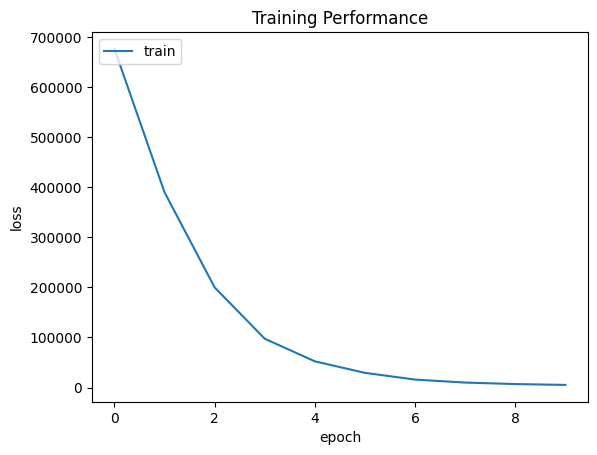

In [ ]:
plt.plot(history.history['loss'])
#plt.plot(history.history['loss'])
plt.title('Training Performance')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
#Evaluation on validation set
seismic_model.SetTest(x, y)
y_hat = seismic_model.Predict()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-10-06 07:53:17.767125: W tensorflow/c/c_api.cc:305] Operation '{name:'decoder/dense_4/Sigmoid' id:248 op device:{requested: '', assigned: ''} def:{{{node decoder/dense_4/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decoder/dense_4/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [ ]:
y_loss = y - y_hat
print(np.argmax(y_loss[0]))
print(np.argmax(y[0]))
print(y[0][100:112])

86595
108
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [ ]:
#Prediction
'''
Input: Model, test data
Output: pd.Dataframe or similar table with evaluation results
'''
#x_input=convert_to_batches_of_data(x_train,100)
seismic_model.SetTest(x_test[:,:429300])
y_hat = seismic_model.Predict()
# use argmax to find the timestamp with the value closest to 1
y_pred = np.argmax(y_hat, axis=1)
# construct a dataframe
df = dataTester.loadPredictions(y_pred)
# save as a csv file
df.to_csv('seismic-detections-'+seismic_model.name+'.csv')

In [ ]:
!rm -rf *.png

In [ ]:
#Demo app
'''
Input: Model, sample input signal
'''